# GA & PSO Comparison

In [4]:
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

## Load GA & PSO Results

In [ ]:
# Paths to results
GA_RESULTS_PATH = "experiments/results/ga/"
PSO_RESULTS_PATH = "experiments/results/pso/"

# Load results
ga_results = pd.read_csv(GA_RESULTS_PATH)
pso_results = pd.read_csv(PSO_RESULTS_PATH)

# Add algorithm labels
ga_results["algorithm"] = "GA"
pso_results["algorithm"] = "PSO"

# Combine results
combined_results = pd.concat([ga_results, pso_results], ignore_index=True)

PermissionError: [Errno 13] Permission denied: '../experiments/results/ga/'

## Plot Boxplots for Fitness & Evaluations

In [14]:
# Plot fitness boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(x="num_companies", y="sharpe_ratio", hue="algorithm", data=combined_results, palette={"GA": "blue", "PSO": "orange"})
plt.title("Fitness Comparison by Portfolio Size")
plt.xlabel("Number of Assets")
plt.ylabel("Sharpe Ratio")
plt.legend(title="Algorithm")
plt.show()

# Plot evaluations boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(x="num_companies", y="n_evaluations", hue="algorithm", data=combined_results, palette={"GA": "blue", "PSO": "orange"})
plt.title("Evaluations Comparison by Portfolio Size")
plt.xlabel("Number of Assets")
plt.ylabel("Number of Evaluations")
plt.legend(title="Algorithm")
plt.show()

NameError: name 'combined_results' is not defined

<Figure size 1200x800 with 0 Axes>

## Wilcoxon Signed-Rank Test for Pairwise Comparison

In [ ]:
alpha = 0.05

# Iterate over unique portfolio sizes
for num_companies in combined_results["num_companies"].unique():
    print(f"\nPortfolio Size: {num_companies}")

    # Filter results for the current portfolio size
    ga_data = combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "GA")]
    pso_data = combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "PSO")]

    # Perform Wilcoxon test for fitness
    stat, p_value = wilcoxon(ga_data["sharpe_ratio"], pso_data["sharpe_ratio"])
    print(f"Fitness - GA Mean: {ga_data['sharpe_ratio'].mean():.4f}, PSO Mean: {pso_data['sharpe_ratio'].mean():.4f}")
    print("The difference in fitness is statistically significant." if p_value < alpha else "The difference in fitness is NOT statistically significant.")

    # Perform Wilcoxon test for evaluations
    stat, p_value = wilcoxon(ga_data["n_evaluations"], pso_data["n_evaluations"])
    print(f"Evaluations - GA Mean: {ga_data['n_evaluations'].mean():.4f}, PSO Mean: {pso_data['n_evaluations'].mean():.4f}")
    print("The difference in evaluations is statistically significant." if p_value < alpha else "The difference in evaluations is NOT statistically significant.")


## Friedman Test for Overall Algorithm Comparison

In [ ]:
from scipy.stats import friedmanchisquare

# Prepare data for Friedman test
fitness_data = [
    combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "GA")]["sharpe_ratio"].values
    for num_companies in combined_results["num_companies"].unique()
] + [
    combined_results[(combined_results["num_companies"] == num_companies) & (combined_results["algorithm"] == "PSO")]["sharpe_ratio"].values
    for num_companies in combined_results["num_companies"].unique()
]

# Perform Friedman test for fitness
stat, p_value = friedmanchisquare(*fitness_data)
print("Friedman Test for Fitness")
print(f"Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
print("The difference in fitness across algorithms is statistically significant." if p_value < alpha else "The difference in fitness across algorithms is NOT statistically significant.")

## Fine-Tuning

Loading selected configurations from: c:\Users\lara\BAO_Portfolio-Optimization-Problem\experiments\results\selected_configs.csv
Performing statistical comparisons...
Wilcoxon Test between GA and PSO: statistic=1.0000, p-value=0.5000


c:\Users\lara\BAO_Portfolio-Optimization-Problem\.venv\Lib\site-packages\scipy\stats\_morestats.py:1967: RuntimeWarning: invalid value encountered in subtract
  y -= x[N//2]  # subtract the median (or a nearby value); see gh-15777


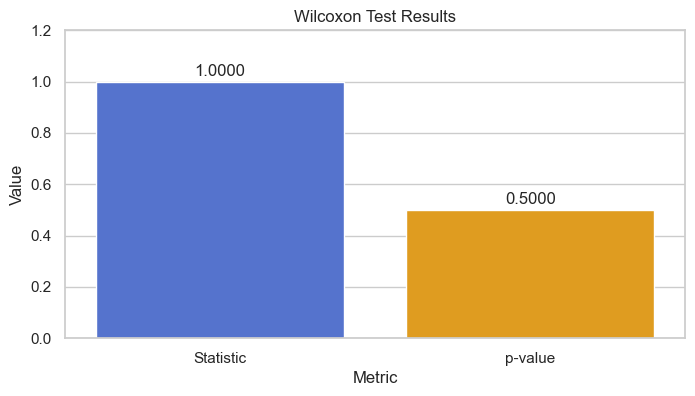

Friedman test requires at least 3 sets of configurations. Skipping Friedman test.


In [15]:
import os
from scipy.stats import wilcoxon, friedmanchisquare, ttest_rel, shapiro

# Plot statistical test results
def plot_statistical_test_results(stat, p_value, test_name):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=["Statistic", "p-value"], y=[stat, p_value], hue=["Statistic", "p-value"], dodge=False, palette=['royalblue', 'orange'])
    plt.title(f"{test_name} Results")
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.ylim(0, max(stat, p_value) * 1.2)  # Adjust the y-axis for better visualization
    for index, value in enumerate([stat, p_value]):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center', va='bottom')
    plt.show()

# Compare configurations using statistical tests
def compare_configs(df):
    print("Performing statistical comparisons...")
    try:
        # Pivot the DataFrame to compare algorithms by quality
        sharpe_values = df.pivot(index="quality", columns="algorithm", values="mean_sharpe")

        # Check if both algorithms are present
        if "GA" not in sharpe_values.columns or "PSO" not in sharpe_values.columns:
            print("One of the algorithms (GA or PSO) is missing from the selected configurations.")
            print("Statistical comparison cannot be performed without both algorithms.")
            return

        # Ensure both columns have equal length
        if len(sharpe_values["GA"]) != len(sharpe_values["PSO"]):
            print("❌ GA and PSO configurations have unequal lengths, skipping paired tests.")
        else:
            # Check for normality using Shapiro-Wilk test
            normal_ga = shapiro(sharpe_values["GA"]).pvalue > 0.05
            normal_pso = shapiro(sharpe_values["PSO"]).pvalue > 0.05
            
            if normal_ga and normal_pso:
                try:
                    # Perform Paired t-test
                    stat, p_value = ttest_rel(sharpe_values["GA"], sharpe_values["PSO"])
                    print(f"Paired t-test between GA and PSO: statistic={stat:.4f}, p-value={p_value:.4f}")
                except Exception as e:
                    print(f"❌ Error during t-test: {e}")
            else:
                try:
                    # Fallback to Wilcoxon if normality is not met
                    stat, p_value = wilcoxon(sharpe_values["GA"], sharpe_values["PSO"])
                    print(f"Wilcoxon Test between GA and PSO: statistic={stat:.4f}, p-value={p_value:.4f}")
                    plot_statistical_test_results(stat, p_value, "Wilcoxon Test")
                except Exception as e:
                    print(f"❌ Error during Wilcoxon test: {e}")

        # Check the number of configurations before performing Friedman Test
        if len(sharpe_values.columns) < 3:
            print("Friedman test requires at least 3 sets of configurations. Skipping Friedman test.")
            return
        
        # Perform the Friedman Test across all available configurations
        try:
            stat, p_value = friedmanchisquare(*[sharpe_values[algo].dropna() for algo in sharpe_values.columns])
            print(f"Friedman Test across configurations: statistic={stat:.4f}, p-value={p_value:.4f}")
            plot_statistical_test_results(stat, p_value, "Friedman Test")
        except Exception as e:
            print(f"❌ Error during Friedman test: {e}")

    except Exception as e:
        print(f"❌ Error during statistical comparison setup: {e}")

# Get the absolute path to the project root
def get_project_root():
    current_dir = os.getcwd()
    while True:
        if os.path.basename(current_dir) == "BAO_Portfolio-Optimization-Problem":
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            # If we reached the root directory without finding the project folder
            raise FileNotFoundError("Project root 'BAO_Portfolio-Optimization-Problem' not found.")
        current_dir = parent_dir

# Construct the path for the results folder
def get_results_path(filename, algorithm=None):
    project_root = get_project_root()
    if algorithm:
        return os.path.join(project_root, "experiments", "results", algorithm, filename)
    return os.path.join(project_root, "experiments", "results", filename)

# Load the selected configurations and compare
try:
    file_path = get_results_path("selected_configs.csv")
    print(f"Loading selected configurations from: {file_path}")
    selected_configs = pd.read_csv(file_path)
    compare_configs(selected_configs)
except FileNotFoundError:
    print("❌ Selected configurations not found.")

## Visualization

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

Comparison of Mean Sharpe Ratios

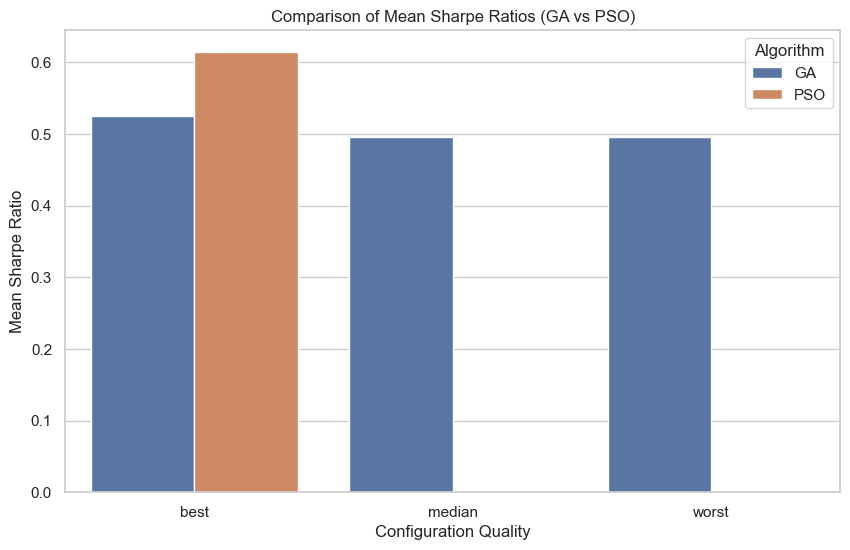

In [9]:
def plot_mean_sharpe_comparison():
    results = pd.read_csv("../experiments/results/selected_configs.csv")
    plt.figure(figsize=(10, 6))

    sns.barplot(data=results, x="quality", y="mean_sharpe", hue="algorithm")
    plt.title("Comparison of Mean Sharpe Ratios (GA vs PSO)")
    plt.xlabel("Configuration Quality")
    plt.ylabel("Mean Sharpe Ratio")
    plt.legend(title="Algorithm")
    plt.show()

plot_mean_sharpe_comparison()

Comparison of Return Distributions

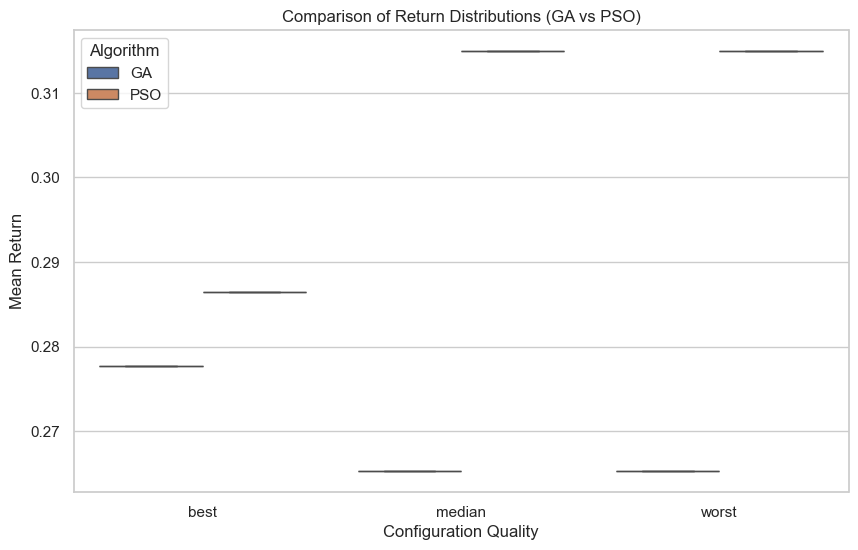

In [11]:
def plot_return_distribution():
    results = pd.read_csv("../experiments/results/selected_configs.csv")
    plt.figure(figsize=(10, 6))

    sns.boxplot(data=results, x="quality", y="mean_return", hue="algorithm")
    plt.title("Comparison of Return Distributions (GA vs PSO)")
    plt.xlabel("Configuration Quality")
    plt.ylabel("Mean Return")
    plt.legend(title="Algorithm")
    plt.show()

plot_return_distribution()

Comparison of Execution Time

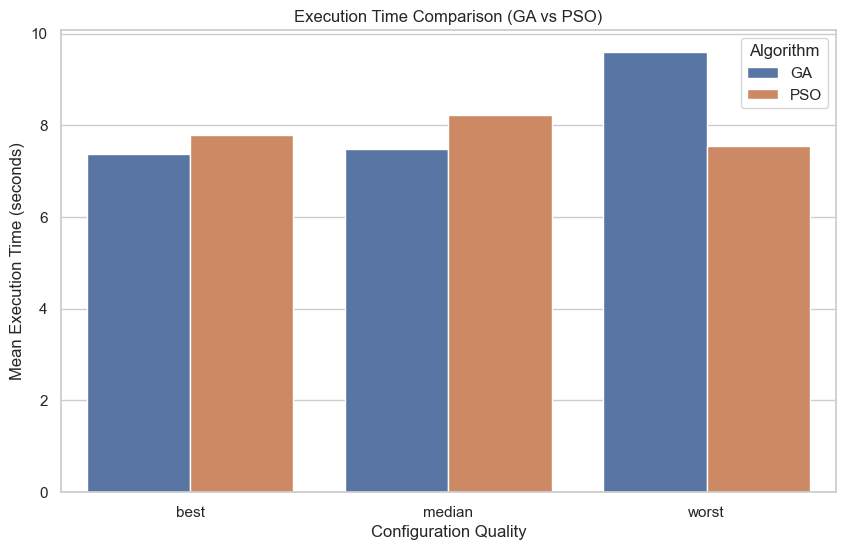

In [12]:
def plot_execution_time():
    results = pd.read_csv("../experiments/results/selected_configs.csv")
    plt.figure(figsize=(10, 6))

    sns.barplot(data=results, x="quality", y="mean_time", hue="algorithm")
    plt.title("Execution Time Comparison (GA vs PSO)")
    plt.xlabel("Configuration Quality")
    plt.ylabel("Mean Execution Time (seconds)")
    plt.legend(title="Algorithm")
    plt.show()

plot_execution_time()

Pairwise Comparison Plot (Best GA vs Best PSO)

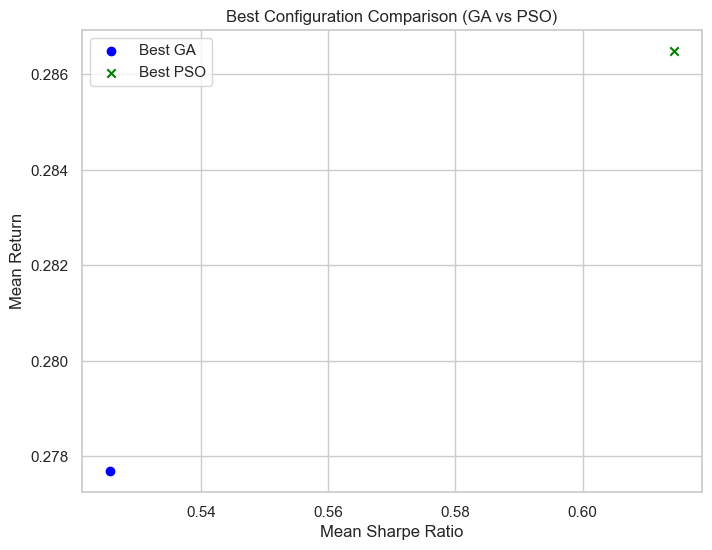

In [13]:
def plot_pairwise_comparison():
    results = pd.read_csv("../experiments/results/selected_configs.csv")
    best_ga = results[(results['algorithm'] == 'GA') & (results['quality'] == 'best')]
    best_pso = results[(results['algorithm'] == 'PSO') & (results['quality'] == 'best')]

    plt.figure(figsize=(8, 6))
    plt.scatter(best_ga['mean_sharpe'], best_ga['mean_return'], label="Best GA", color="blue", marker="o")
    plt.scatter(best_pso['mean_sharpe'], best_pso['mean_return'], label="Best PSO", color="green", marker="x")
    plt.title("Best Configuration Comparison (GA vs PSO)")
    plt.xlabel("Mean Sharpe Ratio")
    plt.ylabel("Mean Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pairwise_comparison()